# Redes Neurais Artificiais 2020.1 -- Projeto Prático 3.4

**Disciplina**: Redes Neurais Artificiais 2020.1  
**Professora**: Elloá B. Guedes (ebgcosta@uea.edu.br)  
**Github**: http://github.com/elloa  
        

Levando em conta a base de dados **_Forest Cover Type_**, esta terceira parte do Projeto Prático 3 diz respeito à proposição e avaliação de múltiplas redes neurais artificiais do tipo feedforward multilayer perceptron para o problema da classificação multi-classe da cobertura florestal em uma área do Roosevelt National Forest.

## Busca em Grade

Uma maneira padrão de escolher os parâmetros de um modelo de Machine Learning é por meio de uma busca em grade via força bruta. O algoritmo da busca em grade é dado como segue:

1. Escolha a métrica de desempenho que você deseja maximizar  
2. Escolha o algoritmo de Machine Learning (exemplo: redes neurais artificiais). Em seguida, defina os parâmetros ou hiperparâmetros deste tipo de modelo sobre os quais você dseja otimizar (número de épocas, taxa de aprendizado, etc.) e construa um array de valores a serem testados para cada parâmetro ou hiperparâmetro.  
3. Defina a grade de busca, a qual é dada como o produto cartesiano de cada parâmetro a ser testado. Por exemplo, para os arrays [50, 100, 1000] e [10, 15], tem-se que a grade é [(50,10), (50,15), (100,10), (100,15), (1000,10), (1000,15)].
4. Para cada combinação de parâmetros a serem otimizados, utilize o conjunto de treinamento para realizar uma validação cruzada (holdout ou k-fold) e calcule a métrica de avaliação no conjunto de teste (ou conjuntos de teste)
5. Escolha a combinação de parâmetros que maximizam a métrica de avaliação. Este é o modelo otimizado.

Por que esta abordagem funciona? Porque a busca em grade efetua uma pesquisa extensiva sobre as possíveis combinações de valores para cada um dos parâmetros a serem ajustados. Para cada combinação, ela estima a performance do modelo em dados novos. Por fim, o modelo com melhor métrica de desempenho é escolhido. Tem-se então que este modelo é o que melhor pode vir a generalizar mediante dados nunca antes vistos.

## Efetuando a Busca em Grade sobre Hiperparâmetros das Top-6 RNAs

Considerando a etapa anterior do projeto prático, foram identificadas pelo menos 6 melhores Redes Neurais para o problema da classificação multi-classe da cobertura florestal no conjunto de dados selecionado. Algumas destas redes possuem atributos categóricos como variáveis preditoras, enquanto outras possuem apenas os atributos numéricos como preditores.

A primeira etapa desta segunda parte do projeto consiste em trazer para este notebook estas seis arquiteturas, ressaltando:

1. Número de neurônios ocultos por camada  
2. Função de Ativação  
3. Utilização ou não de atributos categóricos   
4. Desempenho médio +- desvio padrão nos testes anteriores  
5. Número de repetições que a equipe conseguiu realizar para verificar os resultados  

Elabore uma busca em grade sobre estas arquiteturas que contemple variações nos hiperparâmetros a seguir, conforme documentação de [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

A. Solver  (Não usar o LBFGS, pois é mais adequado para datasets pequenos)  
B. Batch Size  
C. Learning Rate Init  
D. Paciência (n_iter_no_change)  
E. Épocas  

Nesta busca em grande, contemple a utilização do objeto [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

## Validação Cruzada k-fold

Na elaboração da busca em grid, vamos avaliar os modelos propostos segundo uma estratégia de validação cruzada ainda não explorada até o momento: a validação cruzada k-fold. Segundo a mesma, o conjunto de dados é particionado em k partes: a cada iteração, separa-se uma das partes para teste e o modelo é treinado com as k-1 partes remanescentes. Valores sugestivos de k na literatura são k = 3, 5 ou 10, pois o custo computacional desta validação dos modelos é alto. A métrica de desempenho é resultante da média dos desempenhos nas k iterações. A figura a seguir ilustra a ideia desta avaliação

<img src = "https://ethen8181.github.io/machine-learning/model_selection/img/kfolds.png" width=600></img>

Considerando a métrica de desempenho F1-Score, considere a validação cruzada 5-fold para aferir os resultados da busca em grande anterior.

In [8]:
# Local destinado aos imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import plot_confusion_matrix
from joblib import Parallel, delayed
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from joblib import dump, load

print("Import concluido")

Import concluido


In [4]:
# Extraindo o data frame

df = pd.read_csv('./covtype.csv')

df

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396,153,20,85,17,108,240,237,118,837,...,0,0,0,0,0,0,0,0,0,3
581008,2391,152,19,67,12,95,240,237,119,845,...,0,0,0,0,0,0,0,0,0,3
581009,2386,159,17,60,7,90,236,241,130,854,...,0,0,0,0,0,0,0,0,0,3
581010,2384,170,15,60,5,90,230,245,143,864,...,0,0,0,0,0,0,0,0,0,3


In [5]:
# Limpando atributos categóricos

categoricos = []

for i in range(40):
    if(i < 4):
        categoricos.append("Wilderness_Area"+str(i+1))
    categoricos.append("Soil_Type"+str(i+1))

df = df.drop(columns=categoricos)

# Separação dos atributos alvo e preditores.
X_preditor = df.drop(columns=["Cover_Type"])
Y_alvo = df["Cover_Type"]

print("Atributos categóricos removidos")

Atributos categóricos removidos


In [49]:
# top arquiteturas

params = [
         {
            'hl':(4),
            'max_iter': 50,
            'solver': 'adam',
            'activation': 'identity'
         },
         {
            'hl':(10, 6),
            'max_iter': 75,
            'solver': 'adam',
            'activation': 'identity'
         },
         {
            'hl':(12, 13),
            'max_iter': 75,
            'solver': 'adam',
            'activation': 'relu'
         },
         {
            'hl':(10, 5),
            'max_iter': 100,
            'solver': 'adam',
            'activation': 'tanh'
         },
         {
            'hl':(15, 10),
            'max_iter': 50,
            'solver': 'sgd',
            'activation': 'logistic'
         },
         {
            'hl':(15, 10),
            'max_iter': 50,
            'solver': 'adam',
            'activation': 'tanh'
         }          
]
params

[{'hl': 4, 'max_iter': 50, 'solver': 'adam', 'activation': 'identity'},
 {'hl': (10, 6), 'max_iter': 75, 'solver': 'adam', 'activation': 'identity'},
 {'hl': (12, 13), 'max_iter': 75, 'solver': 'adam', 'activation': 'relu'},
 {'hl': (10, 5), 'max_iter': 100, 'solver': 'adam', 'activation': 'tanh'},
 {'hl': (15, 10), 'max_iter': 50, 'solver': 'sgd', 'activation': 'logistic'},
 {'hl': (15, 10), 'max_iter': 50, 'solver': 'adam', 'activation': 'tanh'}]

In [56]:
buscaEmGrade = []

identificador = 1
for param in params:
    print(identificador)
    identificador = identificador + 1

    mplclassifier = MLPClassifier(hidden_layer_sizes=param['hl'],
                        max_iter=param['max_iter'],
                        solver=param['solver'],
                        activation=param['activation'],
                        random_state=1,  
                        verbose=False
                        )
    
    clf = GridSearchCV(mplclassifier, 
                        { "solver": ["sgd", "adam"], "batch_size": [300123],
                            "learning_rate_init": [0.01, 0.02], "n_iter_no_change": [30],
                            "max_iter": [100]
                        }, 
                        scoring={'f1_score': make_scorer(f1_score, average="macro")}, 
                        refit="f1_score")
    
    clf.fit(X_preditor, Y_alvo)

    buscaEmGrade.append(clf)

1


/opt/conda/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:

2


/opt/conda/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/conda/lib/python3.8/site-packages/sklearn/neural_network/_base.py:92: RuntimeWarning: invalid value encountered in subtract
  tmp = X - X.max(axis=1)[:, np.newaxis]
/opt/conda/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/conda/lib/python3.8/site-packages/sklearn/neural_network/_base.py:92: RuntimeWarning: invalid value encountered in subtract
  tmp = X - X.max(axis=1)[:, np.newaxis]
/opt/conda/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and 

3


/opt/conda/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:

4


/opt/conda/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:

5


/opt/conda/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:

6


/opt/conda/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:

## Identificando a mellhor solução

Como resultado da busca em grande com validação cruzada 5-fold, identifique o modelo otimizado com melhor desempenho para o problema. Apresente claramente este modelo, seus parâmetros, hiperparâmetros otimizados e resultados para cada um dos folds avaliados. Esta é a melhor solução identificada em decorrência deste projeto

In [82]:
idx = 0

for i in range(len(buscaEmGrade)):
    if(buscaEmGrade[i].best_score_ > buscaEmGrade[idx].best_score_):
        idx = i

print("========== Modelo com melhor desempenho ==========\n")
        
print("Camadas ocultas:", len(params[i]['hl']))
print("Neurônios na 1ª camada oculta:", params[i]['hl'][0])
if(len(params[i]['hl']) == 2):
      print("Neurônios na 2ª camada oculta:", params[i]['hl'][1])
print("Número máximos de iteração:", params[i]['max_iter'])
print("Sovedolro:", params[i]['solver'])
print("Função de ativação:", params[i]['activation'])

========== Modelo com melhor desempenho ==========

Camadas ocultas: 2
Neurônios na 1ª camada oculta: 15
Neurônios na 2ª camada oculta: 10
Número máximos de iteração: 50
Sovedolro: adam
Função de ativação: tanh


In [91]:
print("========== Hiperparâmetros otimizados ==========\n")

print("Batch size: 300123")
print("Learning Rate Init:", buscaEmGrade[idx].best_params_['learning_rate_init'])
print("Número máximos de iteração:", buscaEmGrade[idx].best_params_['max_iter'])
print("Paciência:", buscaEmGrade[idx].best_params_['n_iter_no_change'])

========== Hiperparâmetros otimizados ==========

Batch size: 300123
Learning Rate Init: 0.02
Número máximos de iteração: 100
Paciência: 30


================= Resultado dos Folds =================



(0.0, 1.0, 0.0, 1.0)

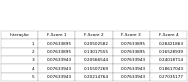

In [110]:
print("================= Resultado dos Folds =================\n")

fscores = []

columns = ("Interação", "F-Score 1", "F-Score 2", "F-Score 3", "F-Score 4", "F-Score 5")

for i in range(1, 6):
    linha = [i]
    
    for j in range(4):
        linha.append(round(buscaEmGrade[idx].cv_results_["split"+str(i-1)+"_test_f1_score"][j], 8))
    
    fscores.append(linha)

fig = plt.figure(dpi = 10)
ax = fig.add_subplot(1, 1, 1)

table = ax.table(cellText=fscores, colLabels=columns)
table.set_fontsize(30)
table.scale(4,5)
ax.axis('off')

## Empacotando a solução

Suponha que você deve entregar este classificador ao órgão responsável por administrar o Roosevelt National Park. Para tanto, você deve fazer uma preparação do mesmo para utilização neste cenário. Uma vez que já identificou os melhores parâmetros e hiperparâmetros, o passo remanescente consiste em treinar o modelo com estes valores e todos os dados disponíveis, salvando o conjunto de pesos do modelo ao final para entrega ao cliente. Assim, finalize o projeto prático realizando tais passos.

1. Consulte a documentação a seguir:
https://scikit-learn.org/stable/modules/model_persistence.html
2. Treine o modelo com todos os dados
3. Salve o modelo em disco  
4. Construa uma rotina que recupere o modelo em disco  
5. Mostre que a rotina é funcional, fazendo previsões com todos os elementos do dataset e exibindo uma matriz de confusão das mesmas

In [7]:
# Treinando o modelo

param = {
            'hl':(15, 10),
            'max_iter': 50,
            'solver': 'adam',
            'activation': 'tanh',
            'batch_size': 30123,
            'learning_rate_init': 0.02,
            'n_iter_no_change': 100,
         }

clf = MLPClassifier(hidden_layer_sizes=param['hl'],
                        activation=param['activation'], 
                        solver=param['solver'], 
                        max_iter=param['max_iter'],
                        batch_size=param['batch_size'],
                        learning_rate_init=param['learning_rate_init'],
                        n_iter_no_change=param['n_iter_no_change'],
                        verbose=False)

    
clf.fit(X_preditor, Y_alvo)


/opt/conda/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='tanh', batch_size=30123, hidden_layer_sizes=(15, 10),
              learning_rate_init=0.02, max_iter=50, n_iter_no_change=100)

In [10]:
# salvando o modelo

dump(clf, 'model.joblib')

['model.joblib']

In [11]:
# Carregando modelo

clf = load('model.joblib')

In [15]:
# Extraindo a predição

predicao = clf.predict(X_preditor)

print(confusion_matrix(predicao, Y_alvo))

[[ 93523  30665      0      0    194     12  16895]
 [117519 223725   2414      1   7122   3650   3539]
 [   798  28908  33340   2746   2177  13705     76]
 [     0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0]
 [     0      3      0      0      0      0      0]]
